In [81]:
import numpy as np
import pandas as pd
import geopandas
from math import sin, cos, acos, radians

from pulp import LpProblem, LpMinimize, LpVariable, LpBinary, lpSum, LpStatus, value, PULP_CBC_CMD

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [82]:
dataset = pd.read_csv(
    'simplemaps_worldcities_basicv1.76\worldcities.csv', 
    usecols = ['city', 'lat', 'lng','iso3', 'population', 'capital', 'admin_name', 'country'])

In [83]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Function to get the country map using ISO code
def get_country_map(iso_code):
    # Check if the ISO code is valid
    if len(iso_code) != 3:
        raise ValueError("Invalid ISO3 code")

    # Load the world map data
    world_data = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Filter the world map data to the specified country
    country_data = world_data[world_data['iso_a3'] == iso_code]

    # Check if the country exists
    if country_data.empty:
        raise ValueError("Country with ISO3 code " + iso_code + " not found")
    plt.show()

# Get the ISO code from the user
iso_code = input("Enter the ISO3 code of the country: ").upper()

# Get the country map
get_country_map(iso_code)

C:\Users\DELL\AppData\Local\Temp\ipykernel_18124\2797837540.py:11: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world_data = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [84]:
df = dataset[dataset['iso3'] == iso_code].reset_index(drop=True)
df.head()

city      lat      lng country iso3   admin_name capital  population
0      Delhi  28.6100  77.2300   India  IND        Delhi   admin  32226000.0
1     Mumbai  19.0761  72.8775   India  IND  Mahārāshtra   admin  24973000.0
2    Kolkāta  22.5675  88.3700   India  IND  West Bengal   admin  18502000.0
3  Bangalore  12.9789  77.5917   India  IND    Karnātaka   admin  15386000.0
4    Chennai  13.0825  80.2750   India  IND   Tamil Nādu   admin  12395000.0

In [85]:
df = df.drop(df[df['population'] < 10000].index).reset_index(drop=True)

In [86]:
row = df.shape[0]
col = df.shape[1]
df = df.dropna(subset=['city', 'lat', 'lng', 'population','admin_name']).reset_index(drop=True)

In [87]:
print(row, col)

4710 8


In [88]:
df

city      lat      lng country iso3      admin_name capital  \
0               Delhi  28.6100  77.2300   India  IND           Delhi   admin   
1              Mumbai  19.0761  72.8775   India  IND     Mahārāshtra   admin   
2             Kolkāta  22.5675  88.3700   India  IND     West Bengal   admin   
3           Bangalore  12.9789  77.5917   India  IND       Karnātaka   admin   
4             Chennai  13.0825  80.2750   India  IND      Tamil Nādu   admin   
...               ...      ...      ...     ...  ...             ...     ...   
4676  Advi Devalpalli  16.6631  79.5139   India  IND  Andhra Pradesh     NaN   
4677          Belpāra  20.5889  82.9729   India  IND          Odisha     NaN   
4678     Jangalapalle  14.8844  79.9107   India  IND  Andhra Pradesh     NaN   
4679    Rangasamudram  14.9852  78.9765   India  IND  Andhra Pradesh     NaN   
4680     Venkatāpuram  18.2232  79.9516   India  IND  Andhra Pradesh     NaN   

      population  
0     32226000.0  
1     24973000.0  
2     18502000.0  
3     15386000.0  
4     12395000.0  
...          ...  
4676     10088.0  
4677     10016.0  
4678     10088.0  
4679     10049.0  
4680     10186.0  

[4681 rows x 8 columns]

In [89]:
REGION_LIST = df['admin_name'].unique()

In [90]:
RANDOM_STATE = 2          # For reproducibility
FRACTION_CUSTOMERS = 0.2  # Fraction of cities we want to keep as customers
FRACTION_WAREHOUSES = 0.8 # Fraction of cities we want to keep as warehouse locations
FRACTION_DEMAND = 0.02    # Fraction of citizens of a city that may order a product  

# List of the 30 regions of country

df['demand'] = np.floor(
    FRACTION_DEMAND * df.population + np.random.uniform(-10, 10, size=(df.shape[0],)))

# Create the warehouses dataframe:
#   1. Filter the 30 regions of country
#   2. Filter capitals as candidate warehouse locations
#   3. Sample a fraction of the original cities
facility_df = df.\
                loc[df.admin_name.isin(REGION_LIST)].\
                loc[df.capital.isin(['admin', 'minor'])].\
                sample(frac=FRACTION_WAREHOUSES, random_state=RANDOM_STATE, ignore_index=True)

# Create the customers dataframe:
#   1. Filter the 30 regions of country
#   2. Sample a fraction of the original cities
customer_df = df.\
                loc[df.admin_name.isin(REGION_LIST)].\
                sample(frac=FRACTION_CUSTOMERS, random_state=RANDOM_STATE, ignore_index=True)

# Customers IDs list
customer_df['customer_id'] = range(1, 1 + customer_df.shape[0])

In [91]:
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler


def get_kmeans(df, num_clusters):
    """
    Executes the K-Means algorithm with weighted or fixed inputs.
    Parameters:
        df (DataFrame): Preprocessed DataFrame.
        num_clusters (int): Number of clusters.
        dataset_type (str): Selected dataset type.
    Returns:
        tuple: Tuple containing the updated DataFrame, cluster labels and centroid centers.
    """

    return K_Means_algo_fixed(df, num_clusters)


def K_Means_algo_fixed(df, num_clusters):
    # Extract latitude and longitude columns
    coordinates = df[['lat', 'lng']]

    # Fit K-means clustering model
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(coordinates)

    # Get the cluster labels
    cluster_labels = kmeans.labels_

    # Get cluster centroids
    centroids = kmeans.cluster_centers_

    # Add the cluster labels to the dataset
    df['Cluster_Kmeans'] = cluster_labels
    return df, cluster_labels, centroids

In [92]:
get_kmeans(df, 5)
df['Cluster_Kmeans'].value_counts()

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster_Kmeans
1    1592
4    1102
2    1046
0     529
3     412
Name: count, dtype: int64

In [93]:
import numpy as np
import pandas as pd
from math import sin, cos, asin, acos, radians
from pulp import LpProblem, LpMinimize, LpVariable, LpBinary, lpSum, LpStatus, value
import matplotlib.pyplot as plt
plt.style.use('ggplot')


def get_pulp(df, num_clusters):
    """
    Executes the Pulp algorithm.
    Parameters:
        df (DataFrame): Preprocessed DataFrame.
        num_clusters (int): Number of clusters.
        dataset_type (str): Selected dataset type.
    Returns:
        tuple: Tuple containing the updated DataFrame, cluster labels and centroid centers.
    """
    return process_data(df, num_clusters)


def process_data(df, num_clusters):
    """
    Use the Pulp model checker to find the solution.
    Parameters:
        df (DataFrame): Preprocessed DataFrame.
        n_warehouses (int): Number of warehouses (clusters).
    Returns:
        tuple: Tuple containing the updated DataFrame, cluster labels and warehouse locations.
    """ 

    #Dictionary of customer and demand
    demand_dict = {customer: df['demand'][i]
                   for i, customer in enumerate(df.index)}
    
    #Mention random state so that the warehouses are not chosen differently every time for the same no. of clusters
    RANDOM_STATE = 2
    
    #Table representing location of warehouses
    new_df = df.sample(n=num_clusters, random_state=RANDOM_STATE)
    new_df = new_df.reset_index()
    
    #Table representing the customer locations same as the original dataframe
    customer_df = df
    
    #Specify the setup cost and the supply per warehouse
    SETUP_COST = 10**5
    SUPPLY_PER_WAREHOUSE = df['demand'].sum() / num_clusters
    SUPPLY_PER_WAREHOUSE += 0.1 * SUPPLY_PER_WAREHOUSE
    
    #Add the column warehouse_id to the warehouses database
    new_df['warehouse_id'] = ['Warehouse' +
                              str(i) for i in range(0, new_df.shape[0])]
    
    #Dictionary of supply and setup cost for each warehouse
    annual_supply_dict = {
        warehouse: SUPPLY_PER_WAREHOUSE for warehouse in new_df['warehouse_id']}
    annual_cost_dict = {
        warehouse: SETUP_COST for warehouse in new_df['warehouse_id']}
    
    #Dictionary representing transport cost from every warehouse to every customer
    transport_costs_dict = {}
    for i in range(new_df.shape[0]):
        warehouse_transport_costs_dict = {}
        for j in customer_df.index:
            if new_df['lat'].iloc[i] == customer_df.loc[j, 'lat'] and new_df['lng'].iloc[i] == customer_df.loc[j, 'lng']:
                d = 0
            else:
                d = haversine_distance(
                    new_df['lat'].iloc[i], new_df['lng'].iloc[i], customer_df.loc[j, 'lat'], customer_df.loc[j, 'lng'])
            warehouse_transport_costs_dict.update({j: travelling_cost(d)})
        transport_costs_dict.update(
            {new_df['warehouse_id'].iloc[i]: warehouse_transport_costs_dict})
    # Note that wherever you used customer_df.index[j] or customer_df['customer_id'][j], you just need to use customer_df.index[j]
    
    #Inititalize the problem
    lp_problem = LpProblem('CFLP', LpMinimize)
    
    #Variable representing whether facility has to be created or not
    created_facility = LpVariable.dicts(
        'Create_facility', new_df['warehouse_id'], 0, 1, LpBinary)
    
    #Variable representing no. of units being served
    served_customer = LpVariable.dicts('Link', [(
        i, j) for i in customer_df.index for j in new_df['warehouse_id']], 0)
    
    #Binary Variable describing whether i customer has been allocated to j warehouse
    bin = LpVariable.dicts('One', [(i, j) for i in customer_df.index
                           for j in new_df['warehouse_id']], 0, 1, LpBinary)
    
    #Specify the objective
    objective = lpSum(annual_cost_dict[j]*created_facility[j] for j in new_df['warehouse_id']) +\
        lpSum(transport_costs_dict[j][i]*served_customer[(i, j)]
              for j in new_df['warehouse_id'] for i in customer_df.index)
    
    #Add the objective to the problem
    lp_problem += objective

    # One User One Inventory
    for i in customer_df.index:
        lp_problem += lpSum(bin[(i, j)] for j in new_df['warehouse_id']) == 1

    # Demand Constraint
    for i in customer_df.index:
        lp_problem += lpSum(served_customer[(i, j)]
                            for j in new_df['warehouse_id']) == demand_dict[i]

    # Capacity Constraint
    for j in new_df['warehouse_id']:
        lp_problem += lpSum(served_customer[(i, j)] for i in customer_df.index
                            ) <= annual_supply_dict[j]*created_facility[j]

    #Solve the problem   
    lp_problem.solve()

    #Dictionary reprenting whcih customers have been assigned to which warehouse
    assigned_customers = {warehouse: []
                          for warehouse in new_df['warehouse_id']}
    for (customer, warehouse), variable in served_customer.items():
        if variable.varValue > 0:
            assigned_customers[warehouse].append(customer)
    
    
    # Calculate total demand for each warehouse
    total_demand_dict = {warehouse: sum(
        demand_dict[customer] for customer in assigned_customers[warehouse]) for warehouse in assigned_customers}
    
    for warehouse, customers in assigned_customers.items():
        assigned_customers[warehouse] = list(set(customers))

    # Check if any customer is assigned to multiple warehouses
    duplicate_customers = []
    for customer in customer_df.index:
        assigned_to_warehouses = []
        for warehouse, customers in assigned_customers.items():
            if customer in customers:
                assigned_to_warehouses.append(warehouse)
        if len(assigned_to_warehouses) > 1:
            duplicate_customers.append(customer)

    # Remove duplicate assignments by keeping the customer assigned to only one warehouse
    for customer in duplicate_customers:
        warehouses = []
        for warehouse, customers in assigned_customers.items():
            if customer in customers:
                warehouses.append(warehouse)
        # Keep the customer assigned to the first warehouse and remove from the others
        for warehouse in warehouses[1:]:
            assigned_customers[warehouse].remove(customer)
            total_demand_dict[warehouse] -= demand_dict[customer]
    
    var_continue = 0
    # Iterate over warehouses to check and reassign if needed
    while any(total_demand > annual_supply_dict[warehouse] for warehouse, total_demand in total_demand_dict.items()):
        # Iterate over warehouses
        for warehouse in assigned_customers:
            if total_demand_dict[warehouse] > annual_supply_dict[warehouse]:
                # Sort assigned customers by demand in descending order
                try:
                    assigned_customers[warehouse].sort(
                        key=lambda customer: transportation_cost(customer, warehouse, customer_df, new_df), reverse=True)
                except:
                    var_continue += 1
                # Reassign customers until capacity is not exceeded or no more reassignments are possible
                while total_demand_dict[warehouse] > annual_supply_dict[warehouse]:
                    reassigned = False

                    # Remove customer with highest demand from the current warehouse
                    customer_to_reassign = assigned_customers[warehouse].pop(0)
                    total_demand_dict[warehouse] -= demand_dict[customer_to_reassign]

                    # Find the closest warehouse with available capacity
                    closest_warehouse = None
                    min_distance = float('inf')
                    for other_warehouse in assigned_customers:
                        if total_demand_dict[other_warehouse] + demand_dict[customer_to_reassign] <= annual_supply_dict[other_warehouse]:
                            distance = haversine_distance(customer_df.loc[customer_to_reassign, 'lat'],
                                                          customer_df.loc[customer_to_reassign, 'lng'],
                                                          new_df.loc[new_df['warehouse_id']
                                                                     == other_warehouse, 'lat'],
                                                          new_df.loc[new_df['warehouse_id'] == other_warehouse, 'lng'])

                            if distance < min_distance:
                                min_distance = distance
                                closest_warehouse = other_warehouse

                    # Reassign the customer to the closest warehouse
                    if closest_warehouse is not None:
                        assigned_customers[closest_warehouse].append(
                            customer_to_reassign)
                        total_demand_dict[closest_warehouse] += demand_dict[customer_to_reassign]
                        reassigned = True

                    # Break the loop if no more reassignments are possible
                    if not reassigned:
                        break    
    
    #Array in which index is representing customer and the value at a particular index is warehouse id
    labels = []
    for i in range(len(customer_df)):
        labels.append(0)

    count = 0
    for warehouse in list(assigned_customers.keys()):
        for j in assigned_customers[warehouse]:
            labels[j] = count
        count += 1

       
    #Convert labels to numpy array and add it as a cluster column in df
    labels = np.asarray(labels)
    demand = df['demand'].to_numpy()
    coordinates = df[['lat', 'lng']].to_numpy()
    centroids = new_df[['lat', 'lng']].to_numpy()
    df['Cluster_Pulp'] = labels
    
    #Return parameters
    return df, labels, centroids

#Calculate Haversine distance between two locations
def haversine_distance(lat1, lon1, lat2, lon2):
    return 6371.01 *\
        acos(sin(radians(lat1))*sin(radians(lat2)) +
             cos(radians(lat1))*cos(radians(lat2))*cos(radians(lon1)-radians(lon2)))

#Calculate Travelling cost when distance is passed as parameter
def travelling_cost(distance):
    petrol_price = 1.87
    mileage = 0.38
    return petrol_price*mileage*distance

#Returns the customer and the warehouse through which it is being served
def get_linked_customers(input_warehouse, served_customer):
    # Initialize empty list
    linked_customers = []

    # Iterate through the xij decision variable
    for (k, v) in served_customer.items():

        # Filter the input warehouse and positive variable values
        if k[1] == input_warehouse and v.varValue > 0:

            # Customer is served by the input warehouse
            linked_customers.append(k[0])

    return linked_customers

#Returns the transportation cost . Either this or travelling_cost can be used
def transportation_cost(customer, warehouse, customer_df, new_df):
    # Retrieve the latitude and longitude of the customer and warehouse
    customer_lat = customer_df.loc[customer_df['customer_id']
                                   == customer, 'lat'].values[0]
    customer_lng = customer_df.loc[customer_df['customer_id']
                                   == customer, 'lng'].values[0]
    warehouse_lat = new_df.loc[new_df['warehouse_id']
                               == warehouse, 'lat'].values[0]
    warehouse_lng = new_df.loc[new_df['warehouse_id']
                               == warehouse, 'lng'].values[0]

    # Calculate the haversine distance between the customer and warehouse
    distance = haversine_distance(
        customer_lat, customer_lng, warehouse_lat, warehouse_lng)

    # Assuming a cost formula based on the distance, calculate the transportation cost
    # You can replace this with your actual cost calculation formula
    cost = distance * 10  # Assuming a cost of $10 per kilometer

    return cost

In [94]:
get_pulp(df, 5)
df['Cluster_Pulp'].value_counts()

C:\Users\DELL\AppData\Local\Temp\ipykernel_18124\4141144219.py:223: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  acos(sin(radians(lat1))*sin(radians(lat2)) +
C:\Users\DELL\AppData\Local\Temp\ipykernel_18124\4141144219.py:224: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cos(radians(lat1))*cos(radians(lat2))*cos(radians(lon1)-radians(lon2)))


Cluster_Pulp
3    1577
2     955
4     940
0     655
1     554
Name: count, dtype: int64

In [95]:
def add_geocoordinates(df, lat='lat', lng='lng'):
    '''
    Add column "geometry" with <shapely.geometry.point.Point> objects 
        built from latitude and longitude values in the input dataframe
    
    Args:
        - df: input dataframe
        - lat: name of the column containing the latitude (default: lat)
        - lng: name of the column containing the longitude (default: lng)
    Out:
        - df: same dataframe enriched with a geo-coordinate column
    '''
    assert pd.Series([lat, lng]).isin(df.columns).all(),\
        f'Cannot find columns "{lat}" and/or "{lng}" in the input dataframe.'
    return geopandas.GeoDataFrame(
        df, geometry=geopandas.points_from_xy(df.lng, df.lat))


customer_df = add_geocoordinates(customer_df)
facility_df = add_geocoordinates(facility_df)

In [ ]:
df.to_csv('df.csv')

In [96]:
customer_df.shape, facility_df.shape

((936, 11), (30, 10))

In [97]:
import pydeck as pdk


def pydeck_density_data(df):
    # Example latitude and longitude data from DataFrame
    latitude = df['lat']
    longitude = df['lng']
    df['demand'] = pd.to_numeric(df['demand'], errors='coerce')

    # Create a pydeck map centered on the average location
    center_lat, center_lon = latitude.mean(), longitude.mean()

    # Normalize the demand values between 0 and 1
    normalized_demand = (df['demand'] - df['demand'].min()) / \
        (df['demand'].max() - df['demand'].min())
    df['NormalizedDemand'] = normalized_demand

    # Create data for pydeck Layer
    data = [{"lat": lat, "lon": lon, "weight": weight}
            for lat, lon, weight in zip(latitude, longitude, normalized_demand)]

    # Create the pydeck Layer
    heatmap_layer = pdk.Layer(
        "HeatmapLayer",
        data=data,
        get_position=["lon", "lat"],
        get_weight="weight",
        opacity=0.5,
    )

    scatterplot_layer = pdk.Layer(
        "ScatterplotLayer",
        data=data,
        get_position=["lon", "lat"],
        get_fill_color=[0, 0, 255],  # Blue points
        get_radius=1000,  # Radius is in meters
    )

    # Create the pydeck Deck object
    deck = pdk.Deck(
        layers=[heatmap_layer, scatterplot_layer],
        initial_view_state=pdk.ViewState(
            latitude=center_lat,
            longitude=center_lon,
            zoom=6,
            pitch=0,
            bearing=0
        ),
        map_style="mapbox://styles/mapbox/light-v10"  # Use a lighter map style
    )

    # Return the deck object
    return deck


In [ ]:
import pulp

def pulp_optimization(problem):
  # Initialize the model
  model = pulp.LpProblem(problem.name)

  # Define the decision variables
  for decision_variable in problem.decision_variables:
    model.addVar(decision_variable.name, decision_variable.lb, decision_variable.ub, decision_variable.type)

  # Define the objective function
  model.setObjective(problem.objective_function.expression, problem.objective_function.sense)

  # Define the constraints
  for constraint in problem.constraints:
    model.addConstraint(constraint.expression, constraint.sense, constraint.rhs)

  # Solve the model
  status = model.solve()

  # Get the optimal solution
  optimal_solution = {}
  for decision_variable in problem.decision_variables:
    optimal_solution[decision_variable.name] = model.getVariable(decision_variable.name).value()

  return optimal_solution

In [98]:
pydeck_density_data(df)

{
  "initialViewState": {
    "bearing": 0,
    "latitude": 20.19654131595813,
    "longitude": 80.70599000213629,
    "pitch": 0,
    "zoom": 6
  },
  "layers": [
    {
      "@@type": "HeatmapLayer",
      "data": [
        {
          "lat": 28.61,
          "lon": 77.23,
          "weight": 1.0
        },
        {
          "lat": 19.0761,
          "lon": 72.8775,
          "weight": 0.7748744810460559
        },
        {
          "lat": 22.5675,
          "lon": 88.37,
          "weight": 0.5740115624878749
        },
        {
          "lat": 12.9789,
          "lon": 77.5917,
          "weight": 0.4772824273464478
        },
        {
          "lat": 13.0825,
          "lon": 80.275,
          "weight": 0.38445194583478837
        },
        {
          "lat": 17.385,
          "lon": 78.4867,
          "weight": 0.3254366973188996
        },
        {
          "lat": 18.5203,
          "lon": 73.8567,
          "weight": 0.2551957474876809
        },
        {
          "lat": 23.03,
          "lon": 72.58,
          "weight": 0.24829705505761843
        },
        {
          "lat": 21.1702,
          "lon": 72.8311,
          "weight": 0.20264462809917355
        },
        {
          "lat": 25.4358,
          "lon": 81.8464,
          "weight": 0.1845202343537811
        },
        {
          "lat": 26.85,
          "lon": 80.95,
          "weight": 0.10468785162767237
        },
        {
          "lat": 26.9,
          "lon": 75.8,
          "weight": 0.09509331470919179
        },
        {
          "lat": 26.4499,
          "lon": 80.3319,
          "weight": 0.08354324292864626
        },
        {
          "lat": 25.146,
          "lon": 82.569,
          "weight": 0.07720948279206923
        },
        {
          "lat": 21.1497,
          "lon": 79.0806,
          "weight": 0.0743646451713033
        },
        {
          "lat": 28.67,
          "lon": 77.42,
          "weight": 0.07345361424746828
        },
        {
          "lat": 22.3,
          "lon": 73.2,
          "weight": 0.0638140689869243
        },
        {
          "lat": 17.7042,
          "lon": 83.2978,
          "weight": 0.06291235013386101
        },
        {
          "lat": 22.7167,
          "lon": 75.8472,
          "weight": 0.06160400419043185
        },
        {
          "lat": 19.1972,
          "lon": 72.9722,
          "weight": 0.05827028285414969
        },
        {
          "lat": 23.25,
          "lon": 77.4167,
          "weight": 0.055515461917510577
        },
        {
          "lat": 18.6186,
          "lon": 73.8037,
          "weight": 0.05337989368719202
        },
        {
          "lat": 25.6,
          "lon": 85.1,
          "weight": 0.051976875024250184
        },
        {
          "lat": 22.09,
          "lon": 82.15,
          "weight": 0.05015481317658014
        },
        {
          "lat": 30.91,
          "lon": 75.85,
          "weight": 0.04995305164319249
        },
        {
          "lat": 27.18,
          "lon": 78.02,
          "weight": 0.048910099716757846
        },
        {
          "lat": 27.18,
          "lon": 78.02,
          "weight": 0.048913203740348424
        },
        {
          "lat": 9.9252,
          "lon": 78.1198,
          "weight": 0.04814806192527063
        },
        {
          "lat": 22.7925,
          "lon": 86.1842,
          "weight": 0.04807356535909673
        },
        {
          "lat": 20.0,
          "lon": 73.78,
          "weight": 0.04583866837387964
        },
        {
          "lat": 28.4167,
          "lon": 77.3,
          "weight": 0.043298025064990496
        },
        {
          "lat": 19.88,
          "lon": 75.32,
          "weight": 0.04227369728009933
        },
        {
          "lat": 22.3,
          "lon": 70.7833,
          "weight": 0.041170216893648394
        },
        {
          "lat": 28.98,
          "lon": 77.71,
          "weight": 0.04022348969852171
        },
        {
          "lat": 23.1667,


In [128]:
import pydeck as pdk

def calculate_color(demand, min_demand, max_demand):
    # Normalize the demand value to a range between 0 and 1
    normalized_demand = (demand - min_demand) / (max_demand - min_demand)

    # Linearly interpolate between green and red
    red = int(255 * normalized_demand)
    green = int(255 * (1 - normalized_demand))

    # Return the color as an array of [red, green, blue, alpha]
    return [red, green, 0, 128]


def pydeck_plot_data(df):
    # Extract latitude, longitude, and demand data from DataFrame
    latitude = df['lat']
    longitude = df['lng']
    demand = df['demand']

    # Create a pydeck map centered on the average location
    center_lat, center_lon = latitude.mean(), longitude.mean()

    # Get the min and max demand values for color calculation and height normalization
    min_demand, max_demand = df['demand'].min(), df['demand'].max()

    # Create data for pydeck Layer
    data = [{"lat": lat, "lon": lon, "elevation": ((demand - min_demand) / (max_demand - min_demand)) * 100000, "color": calculate_color(demand, min_demand, max_demand)}
            for lat, lon, demand in zip(latitude, longitude, demand)]

    plt.figure(figsize=(10, 10))
    # Create the pydeck Layer
    layer = pdk.Layer(
        "ColumnLayer",
        data=data,
        get_position=["lon", "lat"],
        get_elevation="elevation",
        get_fill_color="color",
        radius=1000,  # Radius of column
        elevation_scale=1,
        pickable=True,
        auto_highlight=True,
        get_tooltip=["lat", "lon", "elevation"]  # Add tooltip here
    )

    # Create the pydeck Deck object
    deck = pdk.Deck(
        layers=[layer],
        initial_view_state=pdk.ViewState(
            latitude=center_lat,
            longitude=center_lon,
            zoom=6,
            pitch=45,
            bearing=0
        ),
        map_style="mapbox://styles/mapbox/light-v11"  # Use a lighter map style
    )

    return deck

In [129]:
pydeck_plot_data(df)

{
  "initialViewState": {
    "bearing": 0,
    "latitude": 20.19654131595813,
    "longitude": 80.70599000213629,
    "pitch": 45,
    "zoom": 6
  },
  "layers": [
    {
      "@@type": "ColumnLayer",
      "autoHighlight": true,
      "data": [
        {
          "color": [
            255,
            0,
            0,
            128
          ],
          "elevation": 100000.0,
          "lat": 28.61,
          "lon": 77.23
        },
        {
          "color": [
            197,
            57,
            0,
            128
          ],
          "elevation": 77487.44810460559,
          "lat": 19.0761,
          "lon": 72.8775
        },
        {
          "color": [
            146,
            108,
            0,
            128
          ],
          "elevation": 57401.15624878749,
          "lat": 22.5675,
          "lon": 88.37
        },
        {
          "color": [
            121,
            133,
            0,
            128
          ],
          "elevation": 47728.24273464478,
          "lat": 12.9789,
          "lon": 77.5917
        },
        {
          "color": [
            98,
            156,
            0,
            128
          ],
          "elevation": 38445.194583478835,
          "lat": 13.0825,
          "lon": 80.275
        },
        {
          "color": [
            82,
            172,
            0,
            128
          ],
          "elevation": 32543.669731889964,
          "lat": 17.385,
          "lon": 78.4867
        },
        {
          "color": [
            65,
            189,
            0,
            128
          ],
          "elevation": 25519.574748768093,
          "lat": 18.5203,
          "lon": 73.8567
        },
        {
          "color": [
            63,
            191,
            0,
            128
          ],
          "elevation": 24829.70550576184,
          "lat": 23.03,
          "lon": 72.58
        },
        {
          "color": [
            51,
            203,
            0,
            128
          ],
          "elevation": 20264.462809917357,
          "lat": 21.1702,
          "lon": 72.8311
        },
        {
          "color": [
            47,
            207,
            0,
            128
          ],
          "elevation": 18452.02343537811,
          "lat": 25.4358,
          "lon": 81.8464
        },
        {
          "color": [
            26,
            228,
            0,
            128
          ],
          "elevation": 10468.785162767237,
          "lat": 26.85,
          "lon": 80.95
        },
        {
          "color": [
            24,
            230,
            0,
            128
          ],
          "elevation": 9509.331470919178,
          "lat": 26.9,
          "lon": 75.8
        },
        {
          "color": [
            21,
            233,
            0,
            128
          ],
          "elevation": 8354.324292864627,
          "lat": 26.4499,
          "lon": 80.3319
        },
        {
          "color": [
            19,
            235,
            0,
            128
          ],
          "elevation": 7720.948279206923,
          "lat": 25.146,
          "lon": 82.569
        },
        {
          "color": [
            18,
            236,
            0,
            128
          ],
          "elevation": 7436.46451713033,
          "lat": 21.1497,
          "lon": 79.0806
        },
        {
          "color": [
            18,
            236,
            0,
            128
          ],
          "elevation": 7345.361424746829,
          "lat": 28.67,
          "lon": 77.42
        },
        {
          "color": [
            16,
            238,
            0,
            128
          ],
          "elevation": 6381.406898692429,
          "lat": 22.3,
          "lon": 73.2
        },
        {
          "color": [
            16,
            238,
            0,
            128
          ],
          "elevation": 6291.235013386101,
          "lat": 17.7042,
          "

<Figure size 1000x1000 with 0 Axes>

C:\Users\DELL\AppData\Local\Temp\ipykernel_18124\3189282385.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(gpd.datasets.get_path('naturalearth_lowres'))


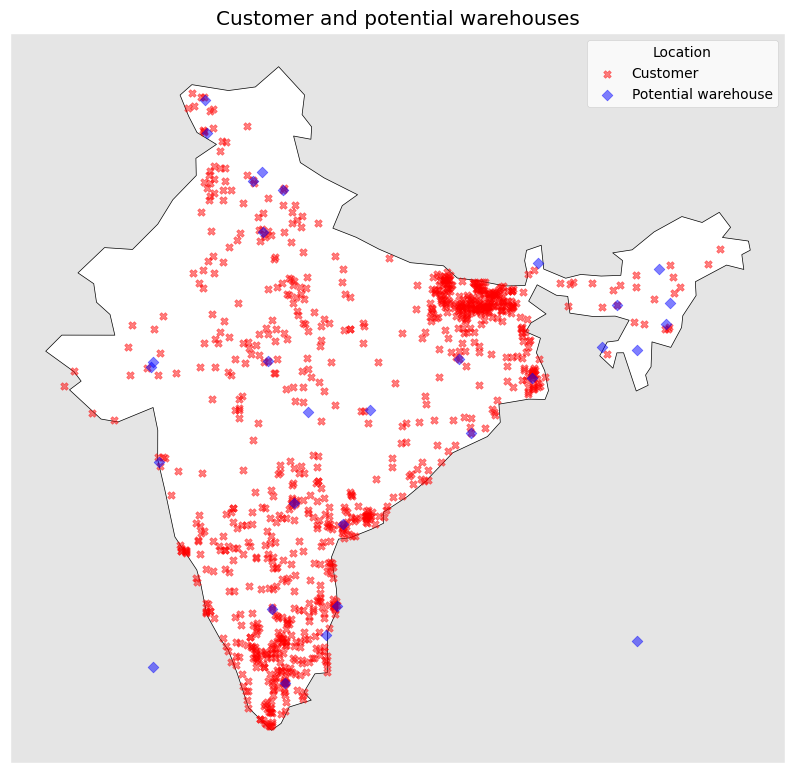

In [99]:
# Prepare country plot
world = geopandas.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract and plot the shape of country
country = world[world.iso_a3 == iso_code]
ax = country.plot(color='white', edgecolor='black', figsize = (10,10), aspect=1.5)

# Plot customers as points
customer_df.\
    plot(ax=ax, marker='X', color='red', markersize=30, alpha=0.5, label='Customer')

# Plot potential facility locations as points
facility_df.\
    plot(ax=ax, marker='D', color='blue', markersize=30, alpha=0.5, label='Potential warehouse')

# Add legend
plt.legend(facecolor='white', title='Location')

# Add title
plt.title('Customer and potential warehouses')

# Remove ticks from axis
plt.xticks([])
plt.yticks([])

# Show plot
plt.show()

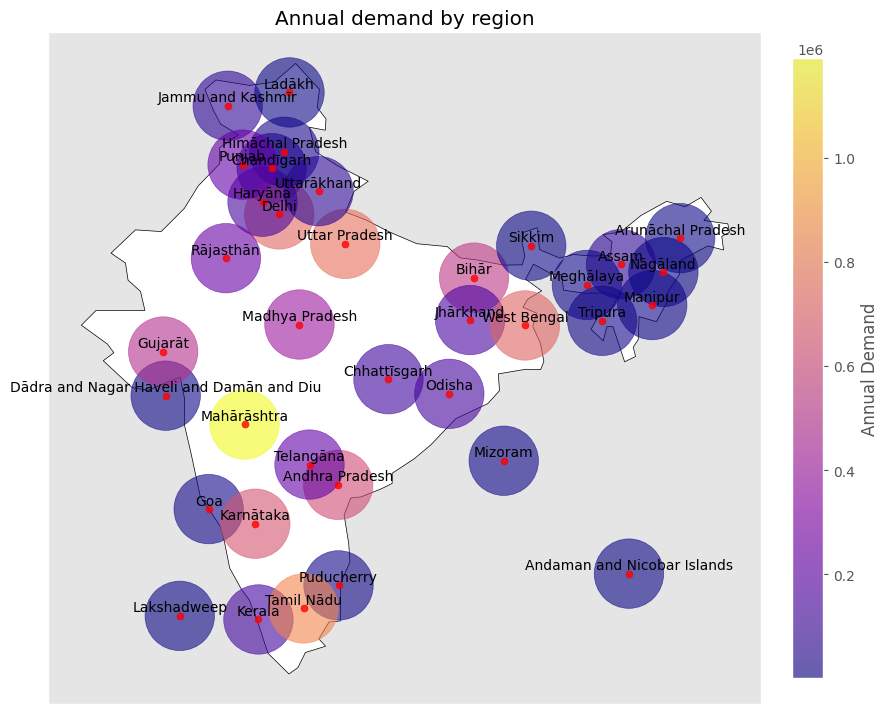

In [100]:
# Prepare region dataframe:
#   1. Filter the 20 regions of Italy
#   2. Group by region
#   3. Calculate:
#      - Mean regional latitude
#      - Mean regional longitude
#      - Sum of regional demand
region_df = df.\
             loc[df.admin_name.isin(REGION_LIST)].\
             groupby(['admin_name']).\
             agg({'lat': 'mean', 'lng': 'mean', 'demand': 'sum'}).\
             reset_index()

# Add geo-coordinates
region_df = add_geocoordinates(region_df)

# Plot the shape of Italy
ax = country.plot(color='white', edgecolor='black', figsize=(10, 10),aspect=1)

# Plot region area colored based on demand
region_df.\
    plot(ax=ax, column='demand', marker='o', c='demand', cmap='plasma', markersize=2500, alpha=0.6)

# Add region 'center' as red dots
region_df.\
    plot(ax=ax, marker='o', c='red', markersize=25, alpha=0.8, label='Customer location')

# Add region name above the center
for i, row in region_df.iterrows():
    plt.annotate(
        row.admin_name, xy=(row.lng, row.lat+0.2), horizontalalignment='center')

# Add color bar with demand scale
plt.colorbar(ax.get_children()[1], ax=ax, label='Annual Demand', fraction=0.04, pad=0.04) 

# Add title
plt.title('Annual demand by region')

# Remove ticks from axis
plt.xticks([])
plt.yticks([])

# Show plot
plt.show()

In [101]:
region_df.sort_values(by='demand', ascending=False)

admin_name        lat        lng     demand  \
20                               Mahārāshtra  19.191878  75.556273  1191433.0   
30                                Tamil Nādu  10.897795  78.216537   834983.0   
33                             Uttar Pradesh  27.335167  80.099828   756422.0   
7                                      Delhi  28.663050  77.122410   721812.0   
35                               West Bengal  23.656907  88.201462   711155.0   
15                                 Karnātaka  14.718284  76.043102   649788.0   
1                             Andhra Pradesh  16.470082  79.781183   615181.0   
4                                      Bihār  25.815099  85.907020   527799.0   
10                                   Gujarāt  22.481490  71.889562   494365.0   
19                            Madhya Pradesh  23.700316  78.033605   402463.0   
28                                 Rājasthān  26.690804  74.717728   239178.0   
27                                    Punjab  30.908020  75.470008   220338.0   
31                                 Telangāna  17.385000  78.486700   209877.0   
14                                 Jhārkhand  23.901345  85.729310   144292.0   
11                                   Haryāna  29.237664  76.368453   128951.0   
25                                    Odisha  20.574235  84.790059   128498.0   
16                                    Kerala  10.400336  76.184636   121120.0   
6                               Chhattīsgarh  21.234421  82.046914   106539.0   
3                                      Assam  26.420662  92.530582    69640.0   
13                         Jammu and Kashmīr  33.563311  74.798355    64363.0   
34                               Uttarākhand  29.712797  78.896721    51770.0   
5                                 Chandīgarh  30.750000  76.780000    21113.0   
12                          Himāchal Pradesh  31.489113  77.351219    19443.0   
9                                        Goa  15.377714  73.941036    13711.0   
32                                   Tripura  23.866140  91.684660    12896.0   
26                                Puducherry  11.936850  79.795200    10890.0   
21                                   Manipur  24.578078  93.940356     9098.0   
23                                   Mizoram  17.557480  87.244320     7966.0   
22                                 Meghālaya  25.484720  90.992620     5760.0   
24                                  Nāgāland  26.065660  94.443620     4611.0   
0                Andaman and Nicobar Islands  12.467233  92.890367     4169.0   
8   Dādra and Nagar Haveli and Damān and Diu  20.492500  72.002200     3002.0   
2                          Arunāchal Pradesh  27.591675  95.199175     2518.0   
29                                    Sikkim  27.250000  88.485000     2251.0   
17                                    Ladākh  34.164200  77.584700      614.0   
18                               Lakshadweep  10.562600  72.636900      232.0   

                     geometry  
20  POINT (75.55627 19.19188)  
30  POINT (78.21654 10.89779)  
33  POINT (80.09983 27.33517)  
7   POINT (77.12241 28.66305)  
35  POINT (88.20146 23.65691)  
15  POINT (76.04310 14.71828)  
1   POINT (79.78118 16.47008)  
4   POINT (85.90702 25.81510)  
10  POINT (71.88956 22.48149)  
19  POINT (78.03360 23.70032)  
28  POINT (74.71773 26.69080)  
27  POINT (75.47001 30.90802)  
31  POINT (78.48670 17.38500)  
14  POINT (85.72931 23.90134)  
11  POINT (76.36845 29.23766)  
25  POINT (84.79006 20.57424)  
16  POINT (76.18464 10.40034)  
6   POINT (82.04691 21.23442)  
3   POINT (92.53058 26.42066)  
13  POINT (74.79836 33.56331)  
34  POINT (78.89672 29.71280)  
5   POINT (76.78000 30.75000)  
12  POINT (77.35122 31.48911)  
9   POINT (73.94104 15.37771)  
32  POINT (91.68466 23.86614)  
26  POINT (79.79520 11.93685)  
21  POINT (93.94036 24.57808)  
23  POINT (87.24432 17.55748)  
22  POINT (90.99262 25.48472)  
24  POINT (94.44362 26.06566)  
0   POINT (92.89037 12.46723)  
8   POINT (7

In [102]:
demand_dict = { customer : customer_df['demand'][i] for i, customer in enumerate(customer_df['customer_id']) }

In [103]:
# Assumptions: 
#    1. Each warehouse has an annual cost of 100.000,00 euros: rent, electricity, ...
#    2. Each warehouse can meet 3 times the regional average annual demand
COST_PER_WAREHOUSE = 100_000
SUPPLY_FACTOR_PER_WAREHOUSE = 3
SUPPLY_PER_WAREHOUSE = region_df.demand.mean() * SUPPLY_FACTOR_PER_WAREHOUSE

# Warehouses list
facility_df['warehouse_id'] = [i for i in range(1, 1 + facility_df.shape[0])]

# Dictionary of warehouse id (id) and max supply (value)
annual_supply_dict = { warehouse : SUPPLY_PER_WAREHOUSE for warehouse in facility_df['warehouse_id'] }

# Dictionary of warehouse id (id) and fixed costs (value)
annual_cost_dict = { warehouse : COST_PER_WAREHOUSE for warehouse in facility_df['warehouse_id'] }

In [104]:
def haversine_distance(lat1, lon1, lat2, lon2):
    '''
    Calculate distance between two locations given latitude and longitude.

    Args:
       - lat1: latitude of the first location
       - lon1: longitude of the first location
       - lat2: latitude of the second location
       - lon2: longitude of the second location
    Out:
       - Distance in Km
    
    Ref: 
       - https://en.wikipedia.org/wiki/Haversine_formula
    '''
    return 6371.01 *\
            acos(sin(radians(lat1))*sin(radians(lat2)) +\
            cos(radians(lat1))*cos(radians(lat2))*cos(radians(lon1)-radians(lon2)))

In [105]:
def traveling_cost(distance_in_km):
    '''
    Return traveling cost in euros given a distance in Km.

    Args:
      - distance_in_km: travel distance in Km
    Out:
      - cost of the trip in euros
    '''
    return 0.71 * distance_in_km

In [106]:
# Dict to store the distances between all warehouses and customers
transport_costs_dict = {}

# For each warehouse location
for i in range(0, facility_df.shape[0]):
    
    # Dict to store the distances between the i-th warehouse and all customers
    warehouse_transport_costs_dict = {}
    
    # For each customer location
    for j in range(0, customer_df.shape[0]):
        
        # Distance in Km between warehouse i and customer j
        d = 0 if facility_df.city[i]==customer_df.city[j] else haversine_distance(
            facility_df.lat[i], facility_df.lng[i], customer_df.lat[j], customer_df.lng[j])
        
        # Update costs for warehouse i
        warehouse_transport_costs_dict.update({customer_df.customer_id[j]: traveling_cost(d)})
    
    # Final dictionary with all costs for all warehouses
    transport_costs_dict.update({facility_df.warehouse_id[i]: warehouse_transport_costs_dict})

In [107]:
customer_df

city      lat      lng country iso3      admin_name capital  \
0    Venkatagirikota  13.0000  78.5000   India  IND  Andhra Pradesh     NaN   
1            Barghāt  22.0306  79.7328   India  IND  Madhya Pradesh     NaN   
2          Hārohalli  12.3204  76.7816   India  IND       Karnātaka     NaN   
3      Lohiyār Ujain  26.6284  84.7452   India  IND           Bihār     NaN   
4        Gokinepalle  16.9228  79.7828   India  IND  Andhra Pradesh     NaN   
..               ...      ...      ...     ...  ...             ...     ...   
931    Perunkolattūr  12.0430  78.9174   India  IND      Tamil Nādu     NaN   
932          Gunupur  19.0800  83.8200   India  IND          Odisha     NaN   
933    Anndevarapeta  17.0937  81.5799   India  IND  Andhra Pradesh     NaN   
934           Telmar  25.4237  85.4358   India  IND           Bihār     NaN   
935          Halwāra  30.7167  75.6500   India  IND          Punjab     NaN   

     population  demand  customer_id                   geometry  
0       12803.0   261.0            1  POINT (78.50000 13.00000)  
1       13742.0   270.0            2  POINT (79.73280 22.03060)  
2       10412.0   215.0            3  POINT (76.78160 12.32040)  
3       12992.0   257.0            4  POINT (84.74520 26.62840)  
4       10836.0   222.0            5  POINT (79.78280 16.92280)  
..          ...     ...          ...                        ...  
931     14749.0   297.0          932  POINT (78.91740 12.04300)  
932     60000.0  1209.0          933  POINT (83.82000 19.08000)  
933     12093.0   236.0          934  POINT (81.57990 17.09370)  
934     13387.0   266.0          935  POINT (85.43580 25.42370)  
935     14551.0   292.0          936  POINT (75.65000 30.71670)  

[936 rows x 11 columns]

In [108]:
facility_df

city      lat      lng country iso3                   admin_name  \
0       Srīnagar  34.0900  74.7900   India  IND            Jammu and Kashmīr   
1         Rānchi  23.3600  85.3300   India  IND                    Jhārkhand   
2       Shillong  25.5744  91.8789   India  IND                    Meghālaya   
3     Port Blair  11.6683  92.7378   India  IND  Andaman and Nicobar Islands   
4         Raipur  21.2500  81.6300   India  IND                 Chhattīsgarh   
5         Nāgpur  21.1497  79.0806   India  IND                  Mahārāshtra   
6         Kohīma  25.6700  94.1000   India  IND                     Nāgāland   
7          Delhi  28.6100  77.2300   India  IND                        Delhi   
8       Itānagar  27.1000  93.6200   India  IND            Arunāchal Pradesh   
9     Puducherry  11.9167  79.8167   India  IND                   Puducherry   
10       Madurai   9.9252  78.1198   India  IND                   Tamil Nādu   
11        Mumbai  19.0761  72.8775   India  IND                  Mahārāshtra   
12   Ghāndīnagar  23.2230  72.6500   India  IND                      Gujarāt   
13     Dehra Dūn  30.3450  78.0290   India  IND                  Uttarākhand   
14        Shimla  31.1033  77.1722   India  IND             Himāchal Pradesh   
15        Āīzawl  23.7272  92.7178   India  IND                      Mizoram   
16     Panchkula  30.7400  76.8000   India  IND                      Haryāna   
17        Bhopāl  23.2500  77.4167   India  IND               Madhya Pradesh   
18       Chennai  13.0825  80.2750   India  IND                   Tamil Nādu   
19     Ahmedabad  23.0300  72.5800   India  IND                      Gujarāt   
20     Bangalore  12.9789  77.5917   India  IND                    Karnātaka   
21     Amarāvati  16.5131  80.5165   India  IND               Andhra Pradesh   
22     Hyderābād  17.3850  78.4867   India  IND                    Telangāna   
23        Imphāl  24.8074  93.9384   India  IND                      Manipur   
24      Agartala  23.8333  91.2833   India  IND                      Tripura   
25     Kavaratti  10.5626  72.6369   India  IND                  Lakshadweep   
26         Jammu  32.7300  74.8700   India  IND            Jammu and Kashmīr   
27       Gangtok  27.3300  88.6200   India  IND                       Sikkim   
28  Bhubaneshwar  20.2700  85.8400   India  IND                       Odisha   
29       Kolkāta  22.5675  88.3700   India  IND                  West Bengal   

   capital  population    demand                   geometry  warehouse_id  
0    admin   1180570.0   23617.0  POINT (74.79000 34.09000)             1  
1    admin   1073440.0   21477.0  POINT (85.33000 23.36000)             2  
2    admin    143229.0    2869.0  POINT (91.87890 25.57440)             3  
3    admin    100608.0    2018.0  POINT (92.73780 11.66830)             4  
4    admin   1010087.0   20197.0  POINT (81.63000 21.25000)             5  
5    admin   2405665.0   48105.0  POINT (79.08060 21.14970)             6  
6    admin     99039.0    1986.0  POINT (94.10000 25.67000)             7  
7    admin  32226000.0  644515.0  POINT (77.23000 28.61000)             8  
8    admin     59490.0    1192.0  POINT (93.62000 27.10000)             9  
9    admin    244377.0    4892.0  POINT (79.81670 11.91670)            10  
10   minor   1561129.0   31213.0   POINT (78.11980 9.92520)            11  
11   admin  24973000.0  499461.0  POINT (72.87750 19.07610)            12  
12   admin    195891.0    3908.0  POINT (72.65000 23.22300)            13  
13   admin    578420.0   11565.0  POINT (78.02900 30.34500)            14  
14   admin    206575.0    4132.0  POINT (77.17220 31.10330)            15  
15   admin    293416.0    5863.0  POINT (92.71780 23.72720)            16  
16   minor    211355.0    4221.0  POINT (76.80000 30.74000)            17  
17   admin   1798218.0   35960.0  POINT (77.41670 23.25000)            18  
18   admin  12395000.0  247902.0  POINT (80.27500 13.08250)            19  
19   minor 

In [109]:
# Define linear problem
lp_problem = LpProblem('CFLP', LpMinimize)


# Variable: y_j (constraint: it is binary)
created_facility = LpVariable.dicts(
    'Create_facility', facility_df['warehouse_id'], 0, 1, LpBinary)

# Variable: x_ij
served_customer = LpVariable.dicts(
    'Link', [(i,j) for i in customer_df['customer_id'] for j in facility_df['warehouse_id']], 0)


# Objective function 
objective = lpSum(annual_cost_dict[j]*created_facility[j] for j in facility_df['warehouse_id']) +\
            lpSum(transport_costs_dict[j][i]*served_customer[(i,j)] \
                  for j in facility_df['warehouse_id'] for i in customer_df['customer_id'])

lp_problem += objective

# Costraint: the demand must be met
for i in customer_df['customer_id']:
    lp_problem += lpSum(served_customer[(i,j)] for j in facility_df['warehouse_id']) == demand_dict[i]

# Constraint: a warehouse cannot deliver more than its capacity limit
for j in facility_df['warehouse_id']:
    lp_problem += lpSum(served_customer[(i,j)] for i in customer_df['customer_id']) <= annual_supply_dict[j] * created_facility[j]

# Constraint: a warehouse cannot give a customer more than its demand
for i in customer_df['customer_id']:
    for j in facility_df['warehouse_id']:
        lp_problem += served_customer[(i,j)] <= demand_dict[i] * created_facility[j]

In [110]:
lp_problem.solve(PULP_CBC_CMD(msg=True))

1

In [111]:
print('Solution: ', LpStatus[lp_problem.status])

Solution:  Optimal


In [112]:
value(lp_problem.objective)

110561404.89399205

In [113]:
created_facility[1].varValue

1.0

In [114]:
# List of the values assumed by the binary variable created_facility
facility_values = [i.varValue for i in created_facility.values()]

# Count of each distinct value of the list
[[i, facility_values.count(i)] for i in set(facility_values)]

[[0.0, 6], [1.0, 24]]

In [115]:
# Create dataframe column to store whether to build the warehouse or not 
facility_df['build_warehouse'] = ''

# Assign Yes/No to the dataframe column based on the optimization binary variable
for i in facility_df['warehouse_id']:
    if created_facility[i].varValue == 1:
        print('Build site at: ', i)
        facility_df.loc[facility_df['warehouse_id'] == i, 'build_warehouse'] = 'Yes'
    else:
        facility_df.loc[facility_df['warehouse_id'] == i, 'build_warehouse'] = 'No'

Build site at:  1
Build site at:  2
Build site at:  3
Build site at:  5
Build site at:  6
Build site at:  7
Build site at:  8
Build site at:  9
Build site at:  10
Build site at:  11
Build site at:  12
Build site at:  14
Build site at:  17
Build site at:  18
Build site at:  19
Build site at:  20
Build site at:  21
Build site at:  22
Build site at:  23
Build site at:  24
Build site at:  27
Build site at:  28
Build site at:  29
Build site at:  30


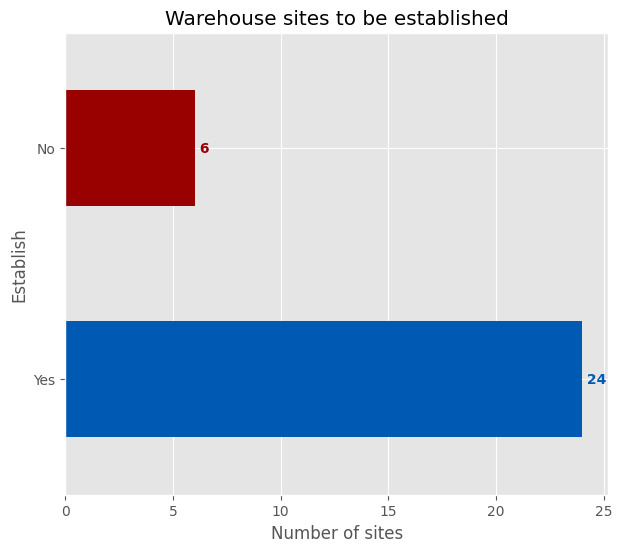

In [116]:
colors = ['#0059b3','#990000']

facility_df.build_warehouse.value_counts().plot.barh(
  title='Warehouse sites to be established', xlabel='Number of sites', color=colors, ylabel='Establish', figsize=(7,6)) 

for i, v in enumerate(facility_df.build_warehouse.value_counts()):
    plt.text(v, i, ' '+str(round(v,3)), color=colors[i], va='center', fontweight='bold')

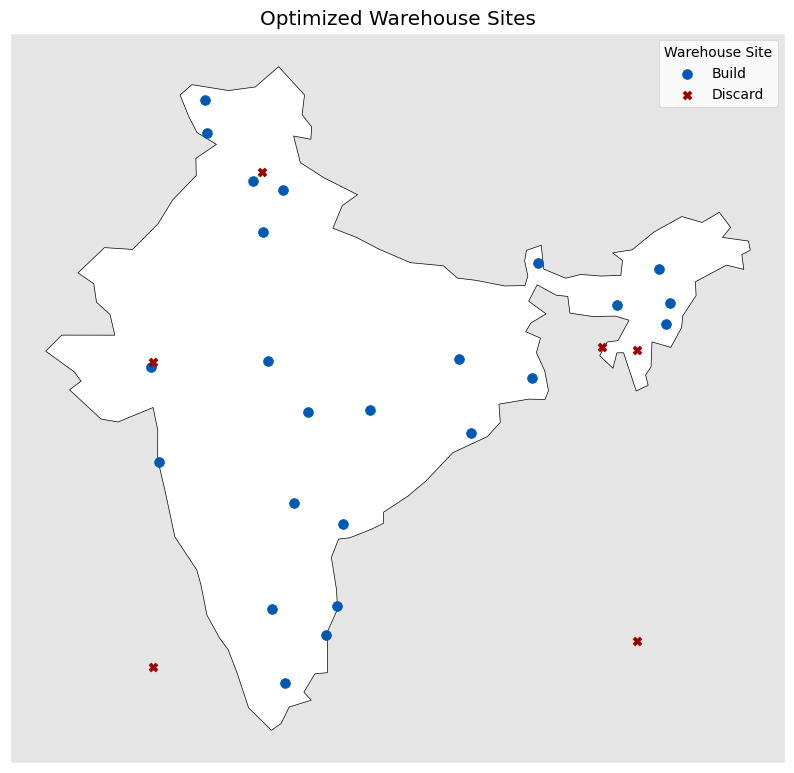

In [117]:
# Plot the shape of Italy
ax = country.plot(color='white', edgecolor='black', figsize=(10, 10))

# Plot sites to establish
facility_df.\
    loc[facility_df.build_warehouse =='Yes'].\
    plot(ax=ax, marker='o', c='#0059b3', markersize=50, label='Build')

# Plot sites to discard
facility_df.\
    loc[facility_df.build_warehouse =='No'].\
    plot(ax=ax, marker='X', c='#990000', markersize=40, label='Discard')

# Add title
plt.title('Optimized Warehouse Sites')

# Add legend
plt.legend(title='Warehouse Site', facecolor='white')

# Remove ticks from axis
plt.xticks([])
plt.yticks([])

# Show plot
plt.show()

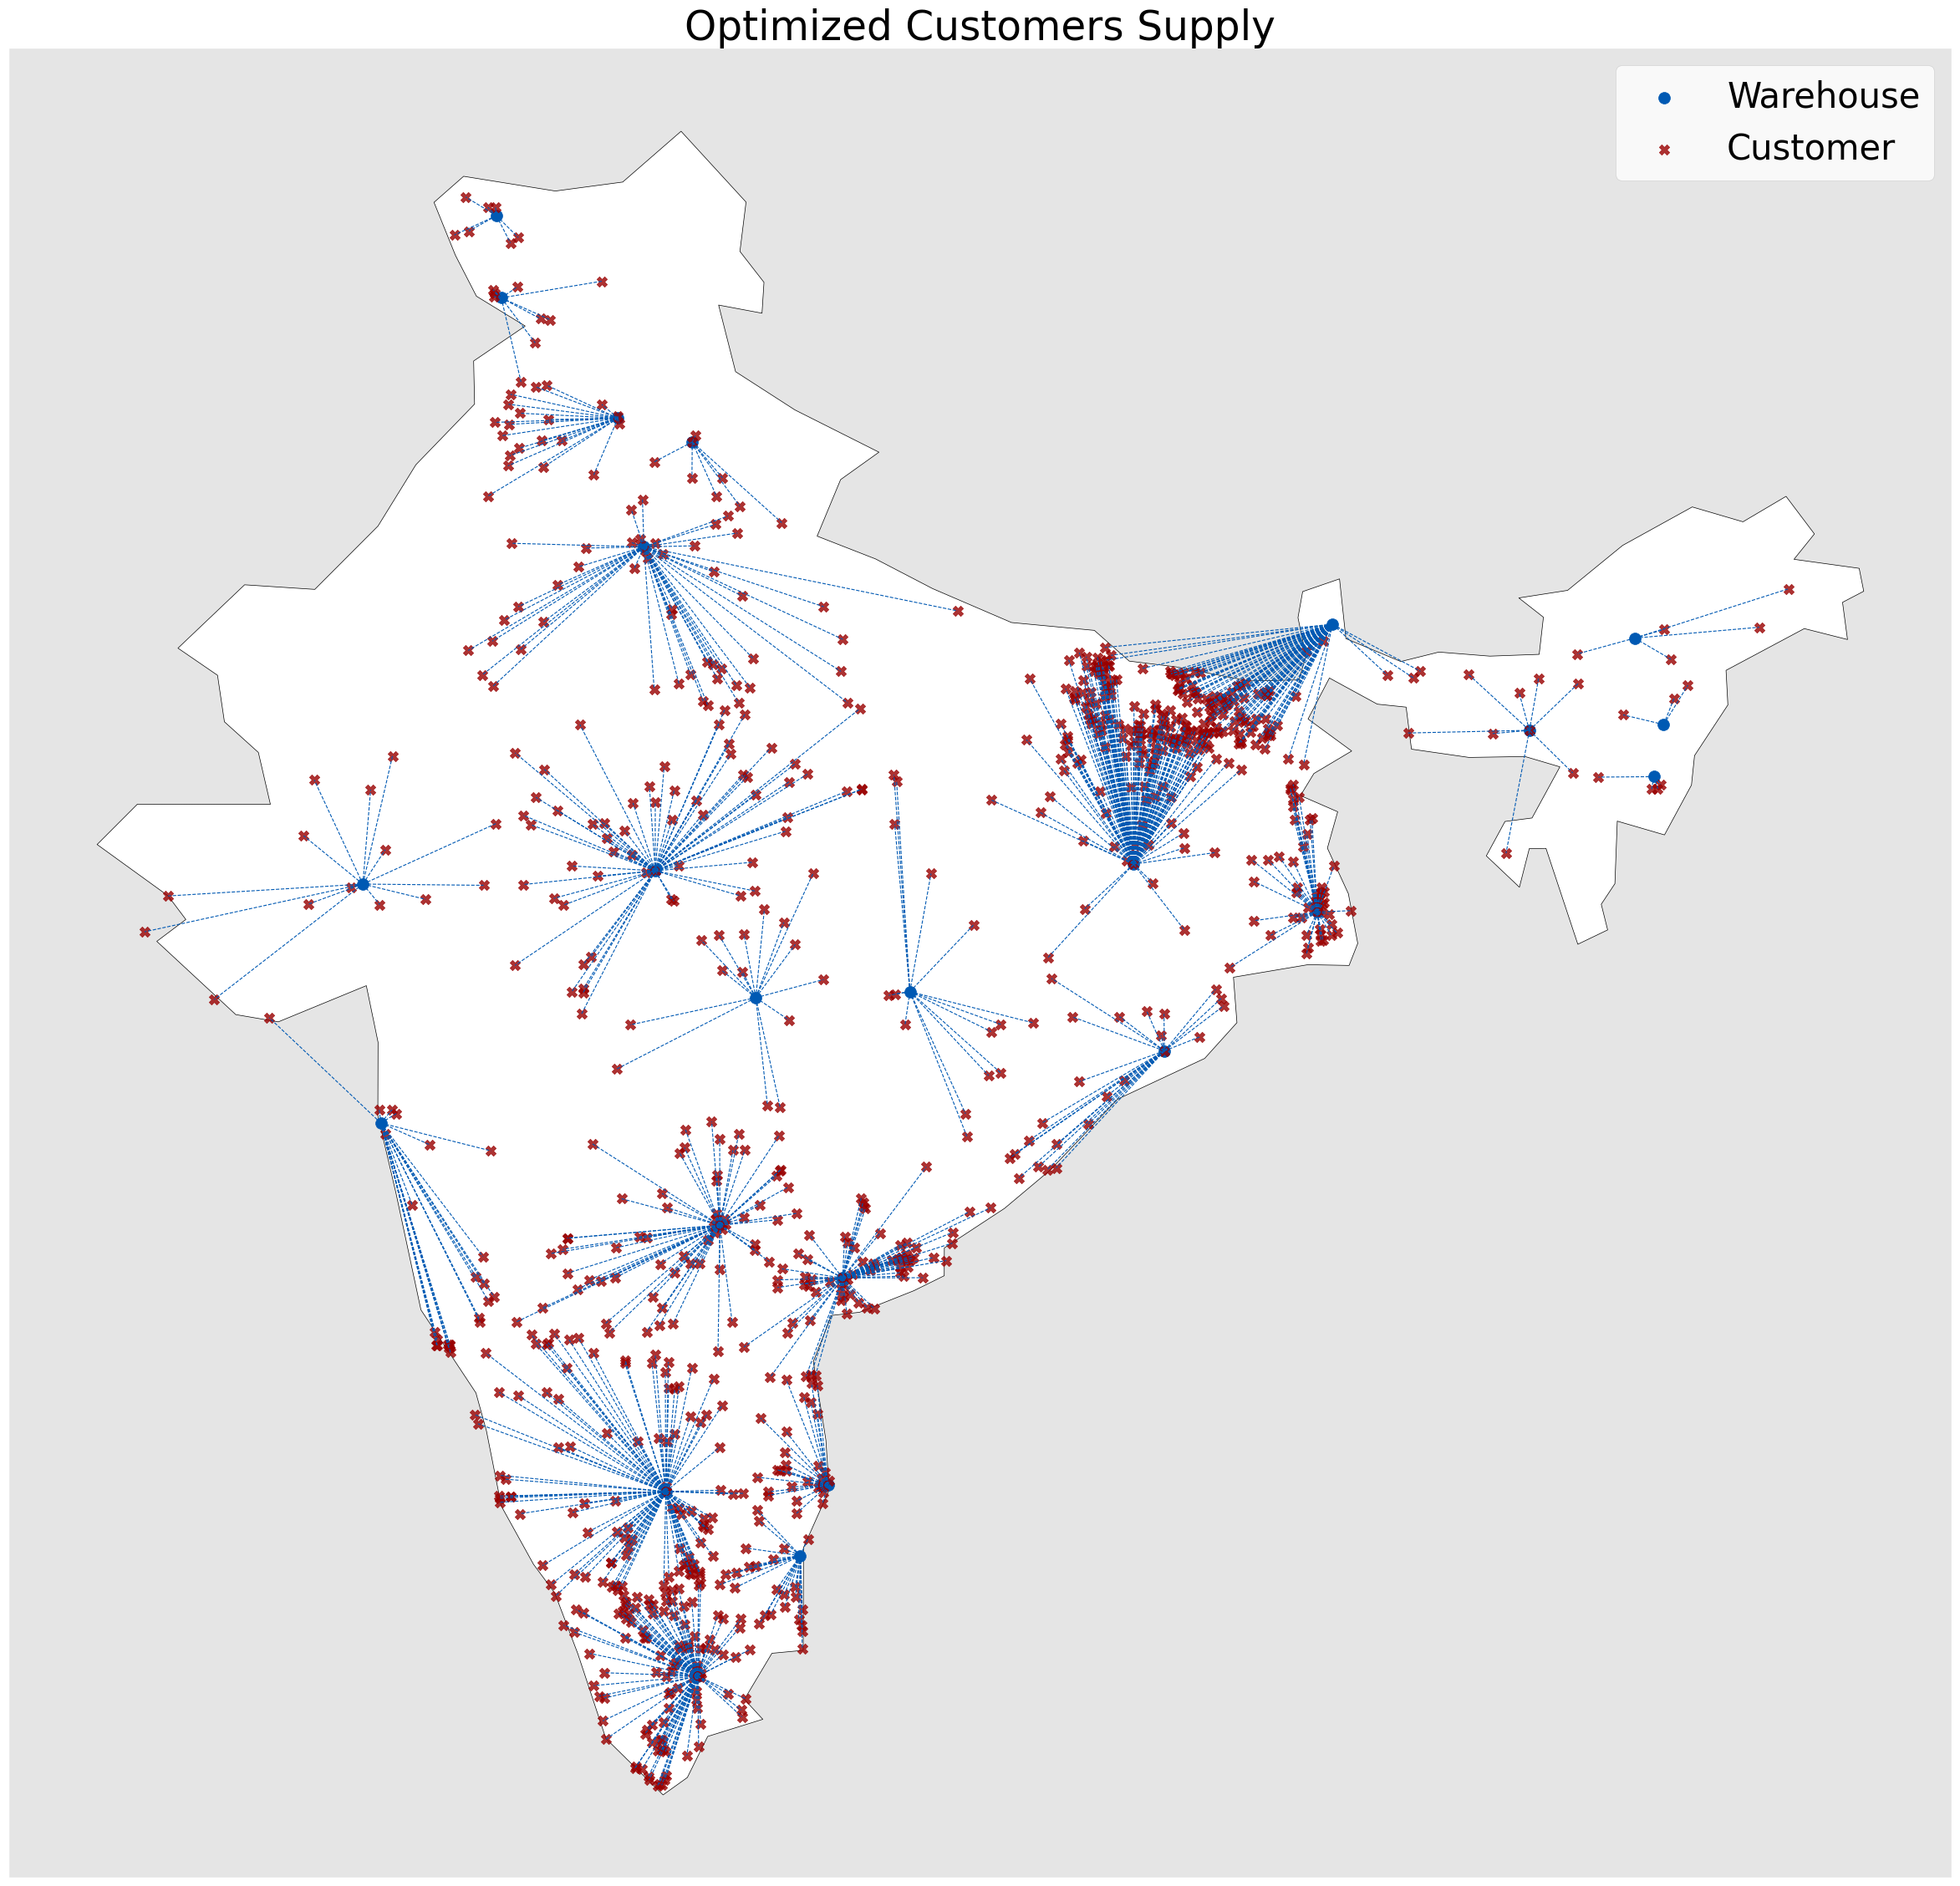

In [118]:
def get_linked_customers(input_warehouse):
    '''
    Find customer ids that are served by the input warehouse.
    
    Args:
        - input_warehouse: string (example: <Warehouse 21>)
    Out:
        - List of customers ids connected to the warehouse
    '''
    # Initialize empty list
    linked_customers = []
    
    # Iterate through the xij decision variable
    for (k, v) in served_customer.items():
            
            # Filter the input warehouse and positive variable values
            if k[1]==input_warehouse and v.varValue>0:
                
                # Customer is served by the input warehouse
                linked_customers.append(k[0])

    return linked_customers


# Warehouses to establish
establish = facility_df.loc[facility_df.build_warehouse =='Yes']

# Plot the shape of Italy
ax = country.plot(color='white', edgecolor='black', figsize=(30, 30))

# Plot sites to establish
establish.\
    plot(ax=ax, marker='o', c='#0059b3', markersize=100, label='Warehouse')

# Plot customers
customer_df.\
    plot(ax=ax, marker='X', color='#990000', markersize=80, alpha=0.8, label='Customer')

# For each warehouse to build
for w in establish.warehouse_id:

    # Extract list of customers served by the warehouse
    linked_customers = get_linked_customers(w)

    # For each served customer
    for c in linked_customers:
    
        # Plot connection between warehouse and the served customer
        ax.plot(
         [establish.loc[establish.warehouse_id==w].lng, customer_df.loc[customer_df.customer_id==c].lng],
         [establish.loc[establish.warehouse_id==w].lat, customer_df.loc[customer_df.customer_id==c].lat],
         linewidth=0.8, linestyle='--', color='#0059b3')

# Add title
plt.title('Optimized Customers Supply', fontsize = 35)

# Add legend
plt.legend(facecolor='white', fontsize=30)

# Remove ticks from axis
plt.xticks([])
plt.yticks([])

# Show plot
plt.show()